In [23]:
import keras
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Conv2D, Conv2DTranspose
from keras.models import Model
import keras.backend as K
import pickle 
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import *
from keras.metrics import *
from scipy.stats import norm
import random
from keras import metrics

In [2]:
data = np.load('./denoising.npy')

In [3]:
batch_size = 16
latent_dim = 128  # Number of latent dimension parameters

input_signal = Input(shape=(np.size(data,1),), name="input")
x = Dense(512, activation='relu', name="intermediate_encoder")(input_signal)
x = Dense(latent_dim, activation='relu', name="latent_encoder")(x)

z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
#z = Lambda(sampling)([z_mu, z_log_sigma])
z = sampling([z_mu, z_log_sigma])

In [5]:
# decoder takes the latent distribution sample as input
decoder_input = Input((latent_dim,), name="input_decoder")

x = Dense(512, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)

# Expand to 784 total pixels
x = Dense(np.size(data,1), activation='sigmoid', name="original_decoder")(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [29]:
# construct a custom layer to calculate the loss
#class CustomVariationalLayer(Layer):

#    def vae_loss(self, x, z_decoded):
#        x = K.flatten(x)
#        z_decoded = K.flatten(z_decoded)
#        # Reconstruction loss
#        xent_loss = binary_crossentropy(x, z_decoded)
#        return xent_loss

    # adds the custom loss to the class
#    def call(self, inputs):
#        x = inputs[0]
#        z_decoded = inputs[1]
#        loss = self.vae_loss(x, z_decoded)
#        self.add_loss(loss, inputs=inputs)
#        return x
    
    
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = np.size(data,1) * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_signal, z_decoded])

In [30]:
vae = Model(input_signal, y)
vae.compile(optimizer='rmsprop', loss=VAE_loss)

In [31]:
index_train =  int(0.7*np.size(data,0))
index_test = int(1*np.size(data,0))

In [32]:
# 70% trainning data, 30% validation data
train_data = data[0:index_train,:]
val_data = data[index_train:index_test,:]
#val_data = np.expand_dims(val_data, axis=1)

In [33]:
vae.fit(x=train_data, y=None,
        epochs=20,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(val_data, None))

Train on 1288 samples, validate on 552 samples
Epoch 1/20
1008/1288 [======================>.......] - ETA: 0s - loss: 1486.4016

InvalidArgumentError: You must feed a value for placeholder tensor 'input_target_5' with dtype float and shape [?,?]
	 [[{{node input_target_5}}]]

In [268]:
n = 10
variable = np.zeros([latent_dim,1])
for i in range(latent_dim):
    variable[i] = random.random()

In [269]:
#z_sample = np.tile(variable, batch_size)#.reshape(batch_size, 2)
x_decoded = decoder.predict(variable.T, batch_size=batch_size)

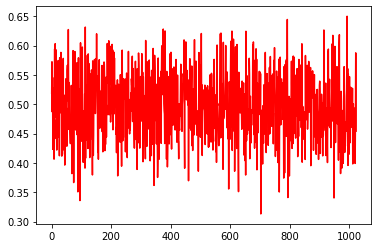

In [270]:
plt.plot(range(np.size(x_decoded,1)),x_decoded[0,:],'r-')

In [ ]:
import tensorflow as tf
tf.reset_default_graph()